# Barren plateaus and vanishing gradients in parameterized quantum circuits

## Definition

In this notebook, we will numerically study the phenomenon of _barren plateaus_ in parameterized quantum circuits (PQCs).

Given a parameterized quantum circuit $U(\theta)$ and an initial state $\ket{\psi(0)}$, define 

$$\ket{\psi(\theta)} := U(\theta)\ket{\psi(0)}.$$ 

If $c$ is some cost function, $c(\ket{\psi(\theta)})$ has a barren plateau if for all indices $j$ and some $k > 0$,
$$
\frac{\partial c}{\partial \theta_j} = O(\exp(-k L))
$$
where $L$ is the number of qubits. 

In practical terms, this means that training of this parameterised circuit does not scale favourably with the number of qubits. 

Barren plateaus were first described [here](https://doi.org/10.1038/s41467-018-07090-4) and have since been extensively studied in the literature (see e.g. Section 6.1 of [this manuscript](https://doi.org/10.1016/j.physrep.2022.08.003) and the citations therein for a more in-depth discussion).

## Numerical characterization of vainishing gradients

It follows from a direct application of [Chebyshev's inequality](https://en.wikipedia.org/wiki/Chebyshev%27s_inequality) that
$$
P\left(\left| \frac{\partial c}{\partial \theta_j} \right| \geq \epsilon \right) \leq \frac{\text{Var}\left(\frac{\partial c}{\partial \theta_j}\right)} {\epsilon^2} 
$$
Thus, if it is the case that $\text{Var}\left(\frac{\partial c}{\partial \theta_j}\right) = O(\exp(-kL))$ for some $k>0$, we are in the presence of a barren plateau. It has been empirically observed that this scaling is independent of the index $j$ chosen; here, we will choose the first angle in the vector of parameters $\theta$.

## Imports

In [1]:
from typing import List, Tuple

import jax
import jax.numpy as jnp
from jax.random import PRNGKey

import qujax
from qujax import all_zeros_statetensor, print_circuit, repeat_circuit

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Define and check ansatz

Here, the PQC will be a hardware efficient ansatz, which is known to have barren plateaus due to its expressibility

In [2]:
def hardware_efficient_ansatz(
    n_qubits: int,
) -> Tuple[List[str], List[List[int]], List[List[int]], int]:
    """
    Builds and returns the circuit specification for a hardware efficient ansatz
    """

    gates: List[str] = []
    qubit_inds: List[List[int]] = []
    param_inds: List[List[int]] = []

    parameter_index = 0

    # Ry layer
    for i in range(n_qubits):
        gates.append("Ry")
        qubit_inds.append([i])
        param_inds.append([parameter_index])
        parameter_index += 1

    # Rx layer
    for i in range(0, n_qubits):
        gates.append("Rx")
        qubit_inds.append([i])
        param_inds.append([parameter_index])
        parameter_index += 1

    # CRz layer
    for i in range(n_qubits - 1):
        gates.append("CZ")
        qubit_inds.append([i, i + 1])
        param_inds.append([])

    return gates, qubit_inds, param_inds, parameter_index

Print one repetition of the circuit to visually check for correctness

In [3]:
gates, qubit_inds, param_inds, nr_of_parameters = hardware_efficient_ansatz(4)

In [4]:
print_circuit(gates, qubit_inds, param_inds);

q0: ---Ry[0]---Rx[4]-----◯-------------------
                         |                   
q1: ---Ry[1]---Rx[5]-----CZ------◯-----------
                                 |           
q2: ---Ry[2]---Rx[6]-------------CZ------◯---
                                         |   
q3: ---Ry[3]---Rx[7]---------------------CZ--


## Define cost function

We will be working with the cost function
$$
    c(\ket{\psi(\theta)}) = \langle \psi (\theta) | X_1 | \psi (\theta) \rangle.
$$
Expectation values are known to present with a barren plateau for sufficiently expressible circuits (such as the hardware efficient ansatz we employ) and sufficiently deep circuits.

In [5]:
observables = [["X"]]
qubits_to_measure = [[1]]
coefficients = [1.0]

# Get function that computes expectation value from quantum state
statetensor_to_expectation_func = qujax.get_statetensor_to_expectation_func(
    observables, qubits_to_measure, coefficients
)

## Measure gradients

Define parameters

In [6]:
n_qubits = [2, 4, 6, 8, 10]
circuit_depth = 100
rng_seed = 0
batch_size = 100
n_batches = 50

print("Total number of gradient samples:", n_batches * batch_size)

Total number of gradient samples: 5000


In [7]:
results_list = []
rng_key = PRNGKey(rng_seed)

for q in n_qubits:
    print(f"Computing variance for {q} qubits")
    # qujax specification of hardware efficient ansatz
    gates, qubit_inds, param_inds, nr_of_parameters = hardware_efficient_ansatz(q)

    # Get function that returns one application of the circuit
    params_to_statetensor = qujax.get_params_to_statetensor_func(
        gates, qubit_inds, param_inds
    )

    # Allow for an arbitrary number of circuit repetitions while avoiding compilation overhead
    repeated_circuit = repeat_circuit(params_to_statetensor, nr_of_parameters)

    def expectation_func(angles: jax.Array, statetensor_in: jax.Array):
        return statetensor_to_expectation_func(repeated_circuit(angles, statetensor_in))

    gradient_func = jax.grad(expectation_func)

    def gradient_of_first_angle(
        angles: jax.Array, statetensor_in: jax.Array
    ) -> jax.Array:
        return gradient_func(angles, statetensor_in)[0]

    # Batched gradient sampling
    vectorized_gradient_of_first_angle = jax.jit(
        jax.vmap(gradient_of_first_angle, (0, None))
    )

    initial_state = all_zeros_statetensor(q)

    sample_list = []
    for i in range(n_batches):
        rng_key, parameters_rng = jax.random.split(rng_key)

        random_angles = jax.random.uniform(
            parameters_rng, (batch_size, circuit_depth * nr_of_parameters)
        )
        samples = vectorized_gradient_of_first_angle(random_angles, initial_state)

        sample_list.append(samples)

    variance = jnp.var(jnp.stack(sample_list))

    print(f"Variance for {q} qubits: {variance:.4f}")

    results_list.append(variance)

Computing variance for 2 qubits
Variance for 2 qubits: 1.3082
Computing variance for 4 qubits
Variance for 4 qubits: 0.3036
Computing variance for 6 qubits
Variance for 6 qubits: 0.0788
Computing variance for 8 qubits
Variance for 8 qubits: 0.0195
Computing variance for 10 qubits
Variance for 10 qubits: 0.0047


# Plot Results

In [8]:
import matplotlib.pyplot as plt

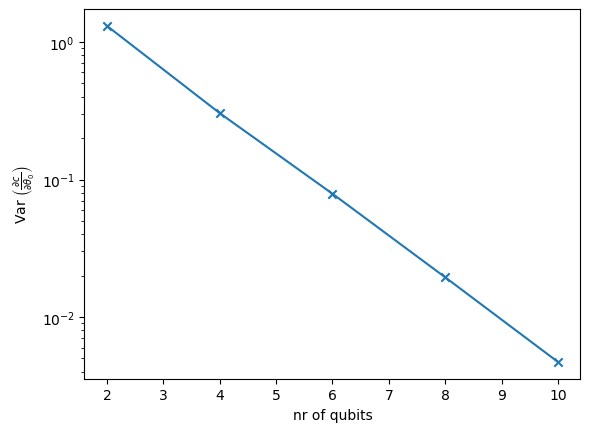

In [9]:
plt.plot(n_qubits, results_list)
plt.scatter(n_qubits, results_list, marker="x")
plt.yscale("log")
plt.xlabel("nr of qubits")
plt.ylabel(r"Var $\left(\frac{\partial c}{\partial \theta_0}\right)$");